### Домашняя работа к уроку 6

In [1]:
import pandas as pd
import numpy as np

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import random
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

#### Подготовка  данных

In [2]:
max_words = 2000
max_len = 40
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [3]:
# предварительно преобразовал файл "отзывы за лето.xsl" в feedbacks.csv c кодировкой UTF-8 чтобы здесь не городить огород.
df = pd.read_csv("data5/feedbacks.csv") 
df

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01
20655,5,Ок,2017-06-01
20656,4,Доволен,2017-06-01
20657,1,"Песопаснасть, рут ни нужын",2017-06-01


In [4]:
df = df.drop(['Date'], axis='columns')
df.head(5)

,Rating,Content
0,5,It just works!
1,4,В целом удобноное приложение...из минусов хотя...
2,5,Отлично все
3,5,Стал зависать на 1% работы антивируса. Дальше ...
4,5,"Очень удобно, работает быстро."


In [5]:
# Разделим данные на 3 части
test_data_size = 1000
test_data_val_size = 5000

df_train = df[:-test_data_size]
df_test = df[-test_data_size:]
df_val = df[-test_data_val_size:]

In [6]:
# сохраним данные в csv
# df_train.to_csv('data5/train.csv')
# df_test.to_csv('data5/test.csv')
# df_val.to_csv('data5/val.csv')

In [7]:
df_train = pd.read_csv("data5/train.csv")
df_test = pd.read_csv("data5/test.csv")
df_val = pd.read_csv("data5/val.csv")

In [8]:
df_train.head()

,Unnamed: 0,Rating,Content
0,0,5,it just works
1,1,4,целое удобноной приложениеиз минус хотеть боль...
2,2,5,отлично
3,3,5,зависать 1 работа антивирус ранее пользоваться...
4,4,5,удобно работать быстро


In [9]:
df_test.head()

,Unnamed: 0,Rating,Content
0,19659,4,дизайннеудобный инекрасивый резать глаз разноц...
1,19660,5,быстро качественно удобно
2,19661,1,поганый приложение постоянно запускаться жрать...
3,19662,4,общий работать
4,19663,5,целое удобно


In [10]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['Content'] = df_train['Content'].apply(preprocess_text)
df_val['Content'] = df_val['Content'].apply(preprocess_text)
df_test['Content'] = df_test['Content'].apply(preprocess_text)

In [11]:
train_corpus = " ".join(df_train["Content"])
train_corpus = train_corpus.lower()

In [12]:
nltk.download("punkt")
tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AVB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Отфильтруем данные и соберём в корпус N наиболее частых токенов

In [13]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [14]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

tokens_filtered_top[10:]
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [15]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [16]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["Content"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["Content"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["Content"]], dtype=np.int32)

In [17]:
x_train.shape

(19659, 40)

In [18]:
x_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,   98,  121,
        105,   75, 1343,  103,   15,  591,  425])

In [19]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [20]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [21]:
class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [22]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

    
train_dataset = DataWrapper(x_train, df_train['Rating'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['Rating'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 305409
Train epoch 1/20
Step 0: loss=-1.696341872215271
Train epoch 2/20
Step 0: loss=-26872.244140625
Train epoch 3/20
Step 0: loss=-266715.5
Train epoch 4/20
Step 0: loss=-1161704.125
Train epoch 5/20
Step 0: loss=-3233557.5
Train epoch 6/20
Step 0: loss=-6872014.5
Train epoch 7/20
Step 0: loss=-13037489.0
Train epoch 8/20
Step 0: loss=-22174294.0
Train epoch 9/20
Step 0: loss=-32938944.0
Train epoch 10/20
Step 0: loss=-46962496.0
Train epoch 11/20
Step 0: loss=-69861224.0
Train epoch 12/20
Step 0: loss=-89509544.0
Train epoch 13/20
Step 0: loss=-121419064.0
Train epoch 14/20
Step 0: loss=-156594592.0
Train epoch 15/20
Step 0: loss=-192120432.0
Train epoch 16/20
Step 0: loss=-236812288.0
Train epoch 17/20
Step 0: loss=-288279616.0
Train epoch 18/20
Step 0: loss=-368675488.0
Train epoch 19/20
St

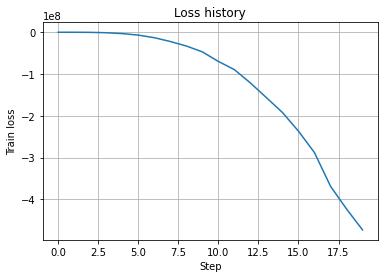

In [23]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history);

In [24]:
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)